In [ ]:
import cv2
import torch
import os
from typing import Any
import torch
from torch import Tensor
from torch import nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import time
import copy
import tqdm
import torchvision.transforms as transforms
from torchmetrics.classification import MultilabelAccuracy, Accuracy
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary

import warnings
warnings.filterwarnings("ignore")

/home/cgac/anaconda3/envs/contactlensEB/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#######################################데이터관련 로드, 검증, 클래스정의, 데이터로더 #####################
#######################################데이터관련 로드, 검증, 클래스정의, 데이터로더 #####################
#######################################데이터관련 로드, 검증, 클래스정의, 데이터로더 #####################
#image broken check
def check_jpeg_eoi(file_path):
    with open(file_path, 'rb') as f:
        f.seek(-2, 2) # 파일의 끝에서 두 바이트 전으로 이동합니다.
        return f.read() == b'\xff\xd9'


def is_image_valid(image_path):
    try:
        img = Image.open(image_path) # 이미지를 열어봅니다.
        img.verify() # verify() 메소드는 파일이 손상되었는지 확인합니다.
        return True
    except (IOError, SyntaxError) as e:
        print('Invalid image: ', image_path, '\n'+ e) # 손상된 이미지에 대한 에러 메시지를 출력합니다.
        return False

#image validation(exist and broken file)
def validate_dataset(df, img_dir):
    count = 0
    df_bar = tqdm.tqdm(df.itertuples(), desc="validating all images", total=len(df))
    for rows in df_bar:
        if os.path.isfile(img_dir+'/'+ rows.id):
            if is_image_valid(img_dir+'/'+ rows.id) and check_jpeg_eoi(img_dir+'/'+ rows.id):
                continue
            else:
                count += 1
                df.drop(df[df['id'] == rows.id].index, inplace=True)
        else:
            count += 1
            df.drop(df[df['id'] == rows.id].index, inplace=True)
        print("Not founded images (Num) : ",count)
    return df

#csv에서 데이터 가져옴
def get_data_from_csv(csv_path, train_ratio, img_dir, randoms_state=42):
    ###### columns example : ['id', 'good', 'b_edge', 'burr', 'borken', 'b_bubble', 'etc', 'no_lens']


    df = pd.read_csv(csv_path)
    df = validate_dataset(df=df,img_dir=img_dir)
    train_df , temp_df = train_test_split(df, test_size=1-train_ratio, random_state=randoms_state)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=randoms_state)


    # 'good' 열을 데이터 프레임에서 제거 및 클래스 재정렬
    cls_list = ['no_lens', 'etc', 'burr', 'borken', 'b_edge', 'b_bubble']
    train_df = train_df.drop(columns=['good'])
    train_df = train_df[['id'] + cls_list]
    val_df = val_df.drop(columns=['good'])
    val_df = val_df[['id'] + cls_list]
    test_df = test_df.drop(columns=['good'])
    test_df = test_df[['id'] + cls_list]


    print('num of train_df',len(train_df))
    print('num of val_df',len(val_df))
    print('num of test_df',len(test_df))

    num_cls = len(train_df.columns) - 1  # because, it is multi-label

    print('number of class: ', num_cls)
    # cls_list = list(train_df.columns)
    # cls_list.remove('id')

    print(cls_list)

    return train_df, val_df, test_df, num_cls, cls_list

#데이터셋 클래스 정의
class CustomDataset(Dataset):

    def __init__(self, dataframe, image_dir, num_classes, class_list, transforms=None, img_resize = False, img_dsize = (640,640)):
        super().__init__()

        self.image_ids = dataframe['id'].unique() # 이미지 고유 ID
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.img_resize = img_resize
        self.img_dsize = img_dsize
        self.class_list = class_list
        self.num_classes = num_classes

    #데이터 길이 검증
    def validate_data_records(self):
        for idx, image_id in enumerate(self.image_ids):
            records = self.df[self.df['id'] == image_id]
            target = np.array(records[self.class_list].values).astype(np.float32)
            if target.shape[1] != len(self.class_list):
                print(f"Index {idx} with image_id {image_id} has mismatched target size. Expected {len(self.class_list)}, but got {target.shape[1]}")


    def __getitem__(self, index: int):
        # 이미지 index로 아이템 불러오기

        image_id = self.image_ids[index]
        records = self.df[self.df['id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)

        # OpenCV가 컬러를 저장하는 방식인 BGR을 RGB로 변환
        if self.img_resize:
            image = cv2.resize(image, self.img_dsize)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0 # 0 ~ 1로 스케일링

        target = np.array(records[self.class_list].values).astype(np.float32)
        target = target.reshape(-1)
        if self.transforms is not None:
            image = self.transforms(image)

        return image, target

    def __len__(self) -> int:
        return self.image_ids.shape[0]

def collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images, 0)

    # Find the maximum target length
    max_len = max([len(t) for t in targets])

    # Pad each target to the maximum length
    targets_padded = [torch.cat([torch.tensor(t), torch.zeros(max_len - len(t))]) for t in targets]

    targets = torch.stack(targets_padded, 0)
    return images, targets

In [ ]:

####################################### 모델구조정의 ##########################################
####################################### 모델구조정의 ##########################################
####################################### 모델구조정의 ##########################################
class TH_InceptionV4(nn.Module):

    def __init__(self, k=192, l=224, m=256, n=384, num_classes=7):
        super(TH_InceptionV4, self).__init__()

        self.stem = InceptionV4Stem(3)

        self.inceptionA1 = InceptionA(384)
        self.inceptionA2 = InceptionA(384)
        self.inceptionA3 = InceptionA(384)
        self.inceptionA4 = InceptionA(384)
        self.no_etc_output_linear = nn.Linear(384, 2)

        self.reductionA = ReductionA(384, k, l, m, n)

        self.inceptionB1 = InceptionB(1024)
        self.inceptionB2 = InceptionB(1024)
        self.inceptionB3 = InceptionB(1024)
        self.inceptionB4 = InceptionB(1024)
        self.inceptionB5 = InceptionB(1024)
        self.inceptionB6 = InceptionB(1024)
        self.inceptionB7 = InceptionB(1024)

        self.burr_broken_output_linear = nn.Linear(1024, 2)

        self.reductionB = ReductionB(1024)

        self.inceptionC1 = InceptionC(1536)
        self.inceptionC2 = InceptionC(1536)
        self.inceptionC3 = InceptionC(1536)

        self.global_average_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(1536, 1)

        # Initialize neural network weights
        self._initialize_weights()

    def forward(self, x):
        outputs = []
        x = self.stem(x)

        x1 = self.inceptionA1(x)
        x2 = self.inceptionA2(x1)
        x3 = self.inceptionA3(x2)
        x4 = self.inceptionA4(x3)

        #no_lens와 etc 클래스 output
        no_etc_output = self.global_average_pooling(x4)
        no_etc_output = torch.flatten(no_etc_output, 1)
        no_etc_output = self.no_etc_output_linear(no_etc_output)
        outputs.append(no_etc_output)

        x_redA = self.reductionA(x4)

        xB1 = self.inceptionB1(x_redA)
        xB2 = self.inceptionB2(xB1)
        xB3 = self.inceptionB3(xB2)
        xB4 = self.inceptionB4(xB3)
        xB5 = self.inceptionB5(xB4)
        xB6 = self.inceptionB6(xB5)
        xB7 = self.inceptionB7(xB6)

        burr_broken_output = self.global_average_pooling(xB7)
        burr_broken_output = torch.flatten(burr_broken_output, 1)
        burr_broken_output = self.burr_broken_output_linear(burr_broken_output)
        outputs.append(burr_broken_output)

        #b_edge분기 - broken에서 받음
        x_redB = self.reductionB(xB7)

        xC1 = self.inceptionC1(x_redB)
        xC2 = self.inceptionC2(xC1)
        xC3 = self.inceptionC3(xC2)

        b_edge_output = self.global_average_pooling(xC3)
        b_edge_output = torch.flatten(b_edge_output, 1)
        b_edge_output = self.linear(b_edge_output)
        outputs.append(b_edge_output)

        #b_bubble분기 - 완전히 따로 내려옴
        x_redA_2 = self.reductionA(x4)

        xB1_2 = self.inceptionB1(x_redA_2)
        xB2_2 = self.inceptionB2(xB1_2)
        xB3_2 = self.inceptionB3(xB2_2)
        xB4_2 = self.inceptionB4(xB3_2)
        xB5_2 = self.inceptionB5(xB4_2)
        xB6_2 = self.inceptionB6(xB5_2)
        xB7_2 = self.inceptionB7(xB6_2)

        x_redB_2 = self.reductionB(xB7_2)

        xC1_2 = self.inceptionC1(x_redB_2)
        xC2_2 = self.inceptionC2(xC1_2)
        xC3_2 = self.inceptionC3(xC2_2)

        b_bubble_output = self.global_average_pooling(xC3_2)
        b_bubble_output = torch.flatten(b_bubble_output, 1)
        b_bubble_output = self.linear(b_bubble_output)
        outputs.append(b_bubble_output)

        final_outputs = torch.cat(outputs, dim=1)
        return final_outputs

    def _initialize_weights(self) -> None:
        for module in self.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                stddev = float(module.stddev) if hasattr(module, "stddev") else 0.1
                torch.nn.init.trunc_normal_(module.weight, mean=0.0, std=stddev, a=-2, b=2)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

class BasicConv2d(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, **kwargs: Any) -> None:
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)
        self.relu = nn.ReLU(True)

    def forward(self, x: Tensor) -> Tensor:
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)

        return out

class InceptionV4Stem(nn.Module):
    def __init__(
            self,
            in_channels: int,
    ) -> None:
        super(InceptionV4Stem, self).__init__()
        self.conv2d_1a_3x3 = BasicConv2d(in_channels, 32, kernel_size=(3, 3), stride=(2, 2), padding=(0, 0))

        self.conv2d_2a_3x3 = BasicConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0))
        self.conv2d_2b_3x3 = BasicConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        self.mixed_3a_branch_0 = nn.MaxPool2d((3, 3), (2, 2))
        self.mixed_3a_branch_1 = BasicConv2d(64, 96, kernel_size=(3, 3), stride=(2, 2), padding=(0, 0))

        self.mixed_4a_branch_0 = nn.Sequential(
            BasicConv2d(160, 64, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            BasicConv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0)),
        )
        self.mixed_4a_branch_1 = nn.Sequential(
            BasicConv2d(160, 64, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            BasicConv2d(64, 64, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3)),
            BasicConv2d(64, 64, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0)),
            BasicConv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0))
        )

        self.mixed_5a_branch_0 = BasicConv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=(0, 0))
        self.mixed_5a_branch_1 = nn.MaxPool2d((3, 3), (2, 2))

    def forward(self, x: Tensor) -> Tensor:
        out = self.conv2d_1a_3x3(x)
        out = self.conv2d_2a_3x3(out)
        out = self.conv2d_2b_3x3(out)

        mixed_3a_branch_0 = self.mixed_3a_branch_0(out)
        mixed_3a_branch_1 = self.mixed_3a_branch_1(out)
        mixed_3a_out = torch.cat([mixed_3a_branch_0, mixed_3a_branch_1], 1)

        mixed_4a_branch_0 = self.mixed_4a_branch_0(mixed_3a_out)
        mixed_4a_branch_1 = self.mixed_4a_branch_1(mixed_3a_out)
        mixed_4a_out = torch.cat([mixed_4a_branch_0, mixed_4a_branch_1], 1)

        mixed_5a_branch_0 = self.mixed_5a_branch_0(mixed_4a_out)
        mixed_5a_branch_1 = self.mixed_5a_branch_1(mixed_4a_out)
        mixed_5a_out = torch.cat([mixed_5a_branch_0, mixed_5a_branch_1], 1)

        return mixed_5a_out

class InceptionV4ResNetStem(nn.Module):
    def __init__(
            self,
            in_channels: int,
    ) -> None:
        super(InceptionV4ResNetStem, self).__init__()
        self.features = nn.Sequential(
            BasicConv2d(in_channels, 32, kernel_size=(3, 3), stride=(2, 2), padding=(0, 0)),
            BasicConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0)),
            BasicConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.MaxPool2d((3, 3), (2, 2)),
            BasicConv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            BasicConv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0)),
            nn.MaxPool2d((3, 3), (2, 2)),
        )
        self.branch_0 = BasicConv2d(192, 96, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
        self.branch_1 = nn.Sequential(
            BasicConv2d(192, 48, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            BasicConv2d(48, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
        )
        self.branch_2 = nn.Sequential(
            BasicConv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            BasicConv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BasicConv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        )
        self.branch_3 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False),
            BasicConv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
        )

    def forward(self, x):
        features = self.features(x)
        branch_0 = self.branch_0(features)
        branch_1 = self.branch_1(features)
        branch_2 = self.branch_2(features)
        branch_3 = self.branch_3(features)

        out = torch.cat([branch_0, branch_1, branch_2, branch_3], 1)

        return out

class InceptionA(nn.Module):
    def __init__(
            self,
            in_channels: int,
    ) -> None:
        super(InceptionA, self).__init__()
        self.branch_0 = BasicConv2d(in_channels, 96, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
        self.branch_1 = nn.Sequential(
            BasicConv2d(in_channels, 64, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            BasicConv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        )
        self.branch_2 = nn.Sequential(
            BasicConv2d(in_channels, 64, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            BasicConv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BasicConv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        )
        self.brance_3 = nn.Sequential(
            nn.AvgPool2d((3, 3), (1, 1), (1, 1), count_include_pad=False),
            BasicConv2d(384, 96, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
        )

    def forward(self, x: Tensor) -> Tensor:
        branch_0 = self.branch_0(x)
        branch_1 = self.branch_1(x)
        branch_2 = self.branch_2(x)
        brance_3 = self.brance_3(x)

        out = torch.cat([branch_0, branch_1, branch_2, brance_3], 1)

        return out

class ReductionA(nn.Module):
    def __init__(
            self,
            in_channels: int,
            k: int,
            l: int,
            m: int,
            n: int,
    ) -> None:
        super(ReductionA, self).__init__()
        self.branch_0 = BasicConv2d(in_channels, n, kernel_size=(3, 3), stride=(2, 2), padding=(0, 0))
        self.branch_1 = nn.Sequential(
            BasicConv2d(in_channels, k, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            BasicConv2d(k, l, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BasicConv2d(l, m, kernel_size=(3, 3), stride=(2, 2), padding=(0, 0)),
        )
        self.branch_2 = nn.MaxPool2d((3, 3), (2, 2))

    def forward(self, x: Tensor) -> Tensor:
        branch_0 = self.branch_0(x)
        branch_1 = self.branch_1(x)
        branch_2 = self.branch_2(x)

        out = torch.cat([branch_0, branch_1, branch_2], 1)

        return out

class InceptionB(nn.Module):
    def __init__(
            self,
            in_channels: int,
    ) -> None:
        super(InceptionB, self).__init__()
        self.branch_0 = BasicConv2d(in_channels, 384, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
        self.branch_1 = nn.Sequential(
            BasicConv2d(in_channels, 192, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            BasicConv2d(192, 224, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3)),
            BasicConv2d(224, 256, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0)),
        )
        self.branch_2 = nn.Sequential(
            BasicConv2d(in_channels, 192, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            BasicConv2d(192, 192, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0)),
            BasicConv2d(192, 224, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3)),
            BasicConv2d(224, 224, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0)),
            BasicConv2d(224, 256, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3)),
        )
        self.branch_3 = nn.Sequential(
            nn.AvgPool2d((3, 3), (1, 1), (1, 1), count_include_pad=False),
            BasicConv2d(in_channels, 128, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
        )

    def forward(self, x: Tensor) -> Tensor:
        branch_0 = self.branch_0(x)
        branch_1 = self.branch_1(x)
        branch_2 = self.branch_2(x)
        branch_3 = self.branch_3(x)

        out = torch.cat([branch_0, branch_1, branch_2, branch_3], 1)

        return out

class ReductionB(nn.Module):
    def __init__(
            self,
            in_channels: int,
    ) -> None:
        super(ReductionB, self).__init__()
        self.branch_0 = nn.Sequential(
            BasicConv2d(in_channels, 192, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            BasicConv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=(0, 0)),
        )
        self.branch_1 = nn.Sequential(
            BasicConv2d(in_channels, 256, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            BasicConv2d(256, 256, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3)),
            BasicConv2d(256, 320, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0)),
            BasicConv2d(320, 320, kernel_size=(3, 3), stride=(2, 2), padding=(0, 0)),
        )
        self.branch_2 = nn.MaxPool2d((3, 3), (2, 2))

    def forward(self, x: Tensor) -> Tensor:
        branch_0 = self.branch_0(x)
        branch_1 = self.branch_1(x)
        branch_2 = self.branch_2(x)

        out = torch.cat([branch_0, branch_1, branch_2], 1)

        return out

class InceptionC(nn.Module):
    def __init__(
            self,
            in_channels: int,
    ) -> None:
        super(InceptionC, self).__init__()
        self.branch_0 = BasicConv2d(in_channels, 256, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))

        self.branch_1 = BasicConv2d(in_channels, 384, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
        self.branch_1_1 = BasicConv2d(384, 256, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
        self.branch_1_2 = BasicConv2d(384, 256, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))

        self.branch_2 = nn.Sequential(
            BasicConv2d(in_channels, 384, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            BasicConv2d(384, 448, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0)),
            BasicConv2d(448, 512, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1)),
        )
        self.branch_2_1 = BasicConv2d(512, 256, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
        self.branch_2_2 = BasicConv2d(512, 256, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))

        self.branch_3 = nn.Sequential(
            nn.AvgPool2d((3, 3), (1, 1), (1, 1)),
            BasicConv2d(in_channels, 256, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
        )

    def forward(self, x: Tensor) -> Tensor:
        branch_0 = self.branch_0(x)
        branch_1 = self.branch_1(x)

        branch_1_1 = self.branch_1_1(branch_1)
        branch_1_2 = self.branch_1_2(branch_1)
        x1 = torch.cat([branch_1_1, branch_1_2], 1)

        branch_2 = self.branch_2(x)
        branch_2_1 = self.branch_2_1(branch_2)
        branch_2_2 = self.branch_2_2(branch_2)
        x2 = torch.cat([branch_2_1, branch_2_2], 1)

        x3 = self.branch_3(x)

        out = torch.cat([branch_0, x1, x2, x3], 1)

        return out


In [ ]:
#####################기타####################
def create_directory(save_path):
    i = 1
    while True:
        dir_name = os.path.join('models/'+save_path+ str(i) +'/')
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
            os.makedirs(dir_name+'/result')
            return dir_name
            break
        i += 1

In [ ]:

####################################### 모델구조정의 ##########################################
####################################### 모델구조정의 ##########################################
####################################### 모델구조정의 ##########################################
class InceptionV4(nn.Module):

    def __init__(
            self,
            k: int = 192,
            l: int = 224,
            m: int = 256,
            n: int = 384,
            num_classes: int = 1000,
    ) -> None:
        super(InceptionV4, self).__init__()
        self.features = nn.Sequential(
            InceptionV4Stem(3),
            InceptionA(384),
            InceptionA(384),
            InceptionA(384),
            InceptionA(384),
            ReductionA(384, k, l, m, n),
            InceptionB(1024),
            InceptionB(1024),
            InceptionB(1024),
            InceptionB(1024),
            InceptionB(1024),
            InceptionB(1024),
            InceptionB(1024),
            ReductionB(1024),
            InceptionC(1536),
            InceptionC(1536),
            InceptionC(1536),
        )

        self.global_average_pooling = nn.AdaptiveAvgPool2d((1, 1))

        self.linear = nn.Linear(1536, num_classes)

        # Initialize neural network weights
        self._initialize_weights()

    def forward(self, x: Tensor) -> Tensor:
        out = self._forward_impl(x)

        return out

    # Support torch.script function
    def _forward_impl(self, x: Tensor) -> Tensor:
        out = self.features(x)
        out = self.global_average_pooling(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)

        return out

    def _initialize_weights(self) -> None:
        for module in self.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                stddev = float(module.stddev) if hasattr(module, "stddev") else 0.1
                torch.nn.init.trunc_normal_(module.weight, mean=0.0, std=stddev, a=-2, b=2)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

class BasicConv2d(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, **kwargs: Any) -> None:
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)
        self.relu = nn.ReLU(True)

    def forward(self, x: Tensor) -> Tensor:
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)

        return out

class InceptionV4Stem(nn.Module):
    def __init__(
            self,
            in_channels: int,
    ) -> None:
        super(InceptionV4Stem, self).__init__()
        self.conv2d_1a_3x3 = BasicConv2d(in_channels, 32, kernel_size=(3, 3), stride=(2, 2), padding=(0, 0))

        self.conv2d_2a_3x3 = BasicConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0))
        self.conv2d_2b_3x3 = BasicConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        self.mixed_3a_branch_0 = nn.MaxPool2d((3, 3), (2, 2))
        self.mixed_3a_branch_1 = BasicConv2d(64, 96, kernel_size=(3, 3), stride=(2, 2), padding=(0, 0))

        self.mixed_4a_branch_0 = nn.Sequential(
            BasicConv2d(160, 64, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            BasicConv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0)),
        )
        self.mixed_4a_branch_1 = nn.Sequential(
            BasicConv2d(160, 64, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            BasicConv2d(64, 64, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3)),
            BasicConv2d(64, 64, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0)),
            BasicConv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0))
        )

        self.mixed_5a_branch_0 = BasicConv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=(0, 0))
        self.mixed_5a_branch_1 = nn.MaxPool2d((3, 3), (2, 2))

    def forward(self, x: Tensor) -> Tensor:
        out = self.conv2d_1a_3x3(x)
        out = self.conv2d_2a_3x3(out)
        out = self.conv2d_2b_3x3(out)

        mixed_3a_branch_0 = self.mixed_3a_branch_0(out)
        mixed_3a_branch_1 = self.mixed_3a_branch_1(out)
        mixed_3a_out = torch.cat([mixed_3a_branch_0, mixed_3a_branch_1], 1)

        mixed_4a_branch_0 = self.mixed_4a_branch_0(mixed_3a_out)
        mixed_4a_branch_1 = self.mixed_4a_branch_1(mixed_3a_out)
        mixed_4a_out = torch.cat([mixed_4a_branch_0, mixed_4a_branch_1], 1)

        mixed_5a_branch_0 = self.mixed_5a_branch_0(mixed_4a_out)
        mixed_5a_branch_1 = self.mixed_5a_branch_1(mixed_4a_out)
        mixed_5a_out = torch.cat([mixed_5a_branch_0, mixed_5a_branch_1], 1)

        return mixed_5a_out

class InceptionV4ResNetStem(nn.Module):
    def __init__(
            self,
            in_channels: int,
    ) -> None:
        super(InceptionV4ResNetStem, self).__init__()
        self.features = nn.Sequential(
            BasicConv2d(in_channels, 32, kernel_size=(3, 3), stride=(2, 2), padding=(0, 0)),
            BasicConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0)),
            BasicConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.MaxPool2d((3, 3), (2, 2)),
            BasicConv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            BasicConv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0)),
            nn.MaxPool2d((3, 3), (2, 2)),
        )
        self.branch_0 = BasicConv2d(192, 96, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
        self.branch_1 = nn.Sequential(
            BasicConv2d(192, 48, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            BasicConv2d(48, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
        )
        self.branch_2 = nn.Sequential(
            BasicConv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            BasicConv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BasicConv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        )
        self.branch_3 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False),
            BasicConv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
        )

    def forward(self, x):
        features = self.features(x)
        branch_0 = self.branch_0(features)
        branch_1 = self.branch_1(features)
        branch_2 = self.branch_2(features)
        branch_3 = self.branch_3(features)

        out = torch.cat([branch_0, branch_1, branch_2, branch_3], 1)

        return out

class InceptionA(nn.Module):
    def __init__(
            self,
            in_channels: int,
    ) -> None:
        super(InceptionA, self).__init__()
        self.branch_0 = BasicConv2d(in_channels, 96, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
        self.branch_1 = nn.Sequential(
            BasicConv2d(in_channels, 64, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            BasicConv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        )
        self.branch_2 = nn.Sequential(
            BasicConv2d(in_channels, 64, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            BasicConv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BasicConv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        )
        self.brance_3 = nn.Sequential(
            nn.AvgPool2d((3, 3), (1, 1), (1, 1), count_include_pad=False),
            BasicConv2d(384, 96, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
        )

    def forward(self, x: Tensor) -> Tensor:
        branch_0 = self.branch_0(x)
        branch_1 = self.branch_1(x)
        branch_2 = self.branch_2(x)
        brance_3 = self.brance_3(x)

        out = torch.cat([branch_0, branch_1, branch_2, brance_3], 1)

        return out

class ReductionA(nn.Module):
    def __init__(
            self,
            in_channels: int,
            k: int,
            l: int,
            m: int,
            n: int,
    ) -> None:
        super(ReductionA, self).__init__()
        self.branch_0 = BasicConv2d(in_channels, n, kernel_size=(3, 3), stride=(2, 2), padding=(0, 0))
        self.branch_1 = nn.Sequential(
            BasicConv2d(in_channels, k, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            BasicConv2d(k, l, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BasicConv2d(l, m, kernel_size=(3, 3), stride=(2, 2), padding=(0, 0)),
        )
        self.branch_2 = nn.MaxPool2d((3, 3), (2, 2))

    def forward(self, x: Tensor) -> Tensor:
        branch_0 = self.branch_0(x)
        branch_1 = self.branch_1(x)
        branch_2 = self.branch_2(x)

        out = torch.cat([branch_0, branch_1, branch_2], 1)

        return out

class InceptionB(nn.Module):
    def __init__(
            self,
            in_channels: int,
    ) -> None:
        super(InceptionB, self).__init__()
        self.branch_0 = BasicConv2d(in_channels, 384, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
        self.branch_1 = nn.Sequential(
            BasicConv2d(in_channels, 192, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            BasicConv2d(192, 224, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3)),
            BasicConv2d(224, 256, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0)),
        )
        self.branch_2 = nn.Sequential(
            BasicConv2d(in_channels, 192, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            BasicConv2d(192, 192, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0)),
            BasicConv2d(192, 224, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3)),
            BasicConv2d(224, 224, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0)),
            BasicConv2d(224, 256, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3)),
        )
        self.branch_3 = nn.Sequential(
            nn.AvgPool2d((3, 3), (1, 1), (1, 1), count_include_pad=False),
            BasicConv2d(in_channels, 128, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
        )

    def forward(self, x: Tensor) -> Tensor:
        branch_0 = self.branch_0(x)
        branch_1 = self.branch_1(x)
        branch_2 = self.branch_2(x)
        branch_3 = self.branch_3(x)

        out = torch.cat([branch_0, branch_1, branch_2, branch_3], 1)

        return out

class ReductionB(nn.Module):
    def __init__(
            self,
            in_channels: int,
    ) -> None:
        super(ReductionB, self).__init__()
        self.branch_0 = nn.Sequential(
            BasicConv2d(in_channels, 192, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            BasicConv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=(0, 0)),
        )
        self.branch_1 = nn.Sequential(
            BasicConv2d(in_channels, 256, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            BasicConv2d(256, 256, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3)),
            BasicConv2d(256, 320, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0)),
            BasicConv2d(320, 320, kernel_size=(3, 3), stride=(2, 2), padding=(0, 0)),
        )
        self.branch_2 = nn.MaxPool2d((3, 3), (2, 2))

    def forward(self, x: Tensor) -> Tensor:
        branch_0 = self.branch_0(x)
        branch_1 = self.branch_1(x)
        branch_2 = self.branch_2(x)

        out = torch.cat([branch_0, branch_1, branch_2], 1)

        return out

class InceptionC(nn.Module):
    def __init__(
            self,
            in_channels: int,
    ) -> None:
        super(InceptionC, self).__init__()
        self.branch_0 = BasicConv2d(in_channels, 256, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))

        self.branch_1 = BasicConv2d(in_channels, 384, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
        self.branch_1_1 = BasicConv2d(384, 256, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
        self.branch_1_2 = BasicConv2d(384, 256, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))

        self.branch_2 = nn.Sequential(
            BasicConv2d(in_channels, 384, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            BasicConv2d(384, 448, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0)),
            BasicConv2d(448, 512, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1)),
        )
        self.branch_2_1 = BasicConv2d(512, 256, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
        self.branch_2_2 = BasicConv2d(512, 256, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))

        self.branch_3 = nn.Sequential(
            nn.AvgPool2d((3, 3), (1, 1), (1, 1)),
            BasicConv2d(in_channels, 256, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
        )

    def forward(self, x: Tensor) -> Tensor:
        branch_0 = self.branch_0(x)
        branch_1 = self.branch_1(x)

        branch_1_1 = self.branch_1_1(branch_1)
        branch_1_2 = self.branch_1_2(branch_1)
        x1 = torch.cat([branch_1_1, branch_1_2], 1)

        branch_2 = self.branch_2(x)
        branch_2_1 = self.branch_2_1(branch_2)
        branch_2_2 = self.branch_2_2(branch_2)
        x2 = torch.cat([branch_2_1, branch_2_2], 1)

        x3 = self.branch_3(x)

        out = torch.cat([branch_0, x1, x2, x3], 1)

        return out


In [ ]:
########################################## 학습 매커니즘 설정 #####################################
########################################## 학습 매커니즘 설정 #####################################
########################################## 학습 매커니즘 설정 #####################################

# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# function to start training
def train_val(model, device, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}
    metric_cls_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())


    for epoch in range(num_epochs):
        start_time = time.time()
        current_lr = get_lr(opt)

        print(f"Epoch {epoch}/{num_epochs-1}")

        model.train()
        train_loss, train_metric,train_cls_metric = loss_epoch_multi_output(model, device, loss_func, train_dl, sanity_check, opt)

        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric.item())

        metric_cls_history['train'].append(train_cls_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric,val_cls_metric = loss_epoch_multi_output(model, device, loss_func, val_dl, sanity_check)

        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric.item())

        metric_cls_history['val'].append(val_cls_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        if isinstance(model, torch.nn.DataParallel):
        # model.module is the original model before DataParallel
            torch.save(model.module.state_dict(), path2weights + f'{epoch}_weight.pt')
        else:
            torch.save(model.state_dict(), path2weights + f'{epoch}_weight.pt')

        # torch.save(model.module.state_dict(), path2weights + f'{epoch}_weight.pt')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print(f'train loss: {train_loss:.6f}, val loss: {val_loss:.6f}, accuracy: {val_metric:.2f},cls_acc : {val_cls_metric}, time: {(time.time()-start_time)/60:.4f} min')
        lossdf = pd.DataFrame(loss_history)
        accdf = pd.DataFrame(metric_history)
        acc_clsdf = pd.DataFrame(metric_cls_history)

        lossdf.to_csv(path2weights + 'result/loss.csv')
        accdf.to_csv(path2weights + 'result/acc.csv')
        acc_clsdf.to_csv(path2weights + 'result/cls_acc.csv')


    # model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history, metric_cls_history

def metric_batch_multi_output(output, target, device):
    # output: [batch_size, num_classes], target: [batch_size, num_classes]

    pred = output.sigmoid() >= 0.5

    num_classes = target.shape[1]
    mla_ova = MultilabelAccuracy(num_labels=num_classes).to(device=device)
    mla = MultilabelAccuracy(num_labels=num_classes, average=None).to(device=device)

    class_accuracies = mla(pred, target)
    overall_accuracy = mla_ova(pred, target)

    return class_accuracies, overall_accuracy


def loss_batch_multi_output(loss_func, output, target, device, opt=None):
    # output: [batch_size, num_classes], target: [batch_size, num_classes]
    loss_b = loss_func(output, target)
    class_metric_b , metric_b = metric_batch_multi_output(output, target, device)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item(), metric_b, class_metric_b

def loss_epoch_multi_output(model, device, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    running_class_metrics = torch.zeros(dataset_dl.dataset.num_classes).to(device)
    len_data = len(dataset_dl.dataset)
    num_classes = dataset_dl.dataset.num_classes
    b_count = 0
    with tqdm.tqdm(dataset_dl, unit="batch") as tepoch:
        for xb, yb in tepoch:
            b_count+=1
            xb = xb.to(device)
            yb = yb.to(device)
            output = model(xb)

            loss_b, metric_b, class_metric_b = loss_batch_multi_output(loss_func, output, yb, device, opt)

            running_loss += loss_b

            if metric_b is not None:
                running_metric += metric_b

            if class_metric_b is not None:
                running_class_metrics += class_metric_b

            if sanity_check is True:
                break

    loss = running_loss / b_count
    metric = running_metric / b_count # 수정된 부분
    class_metrics = {f'class_{i+1}': (running_class_metrics[i] / b_count).item() for i in range(num_classes)}
    return loss, metric, class_metrics

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except os.OSerror:
        print('Error')
createFolder('./models')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.reset_max_memory_allocated(device=None)
torch.cuda.empty_cache()
print(device)

cuda


In [ ]:
############################# 여기는 전체 데이터셋에서 샘플만 추출하는 과정임 #################################

# data_df = pd.read_csv('dataset.csv')
# data_df.sum()

# categories = ['good', 'b_edge', 'burr', 'borken', 'b_bubble', 'etc', 'no_lens']

# resampled_dfs = []
# used_indices = set()  # 이미 사용된 인덱스를 추적합니다.

# for category in categories:
#     # 이미 선택된 샘플을 제외한 데이터프레임을 생성합니다.
#     available_data = data_df.drop(index=used_indices)

#     # 각 카테고리별로 데이터프레임을 필터링합니다.
#     category_df = available_data[available_data[category] == 1] # 카테고리별로 적절한 필터링 조건을 적용해야 합니다.

#     # 해당 카테고리에서 사용 가능한 샘플 수가 900개를 초과하는지 확인합니다.
#     if len(category_df) > 900:
#         category_df = category_df.sample(n=400, random_state=42) # 무작위 샘플 선택
#         used_indices.update(category_df.index)  # 선택된 인덱스를 사용된 인덱스 집합에 추가합니다.
#     else:
#         used_indices.update(category_df.index)  # 남은 모든 샘플 사용

#     resampled_dfs.append(category_df)

# # 모든 카테고리의 데이터프레임을 하나로 병합합니다.
# balanced_df = pd.concat(resampled_dfs, ignore_index=True)

# # 결과를 확인합니다.
# print(balanced_df.sum())

# balanced_df.to_csv('TH_dataset.csv', index=False)

In [ ]:
model_origin = InceptionV4(num_classes=6)
model_origin.load_state_dict(torch.load('models/gnet4_2/36_weight.pt'))
model_TH = TH_InceptionV4()
model_TH.load_state_dict(torch.load('models/TH_gnet4_3/33_weight.pt'))

################## gpu사용처리 ######################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.reset_max_memory_allocated(device=None)
torch.cuda.empty_cache()
num_device = torch.cuda.device_count()
print(device)

model_origin = model_origin.to(device=device)
model_TH = model_TH.to(device=device)


cuda


In [ ]:
csv_path = 'TH_dataset.csv'
img_dir = './data/images2/'

IMG_SIZE = 640
BATCH_SIZE = 96
EPOCH = 200

In [ ]:
train_ratio = 0.6
train_df, val_df, test_df, NUM_CLS, cls_list = get_data_from_csv(csv_path=csv_path,img_dir=img_dir, train_ratio=train_ratio, randoms_state=42)
transformation = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(IMG_SIZE)
])

train_set = CustomDataset(train_df,num_classes=NUM_CLS, image_dir=img_dir, class_list= cls_list ,img_resize=True, img_dsize=(IMG_SIZE,IMG_SIZE))
train_set.transforms = transformation

val_set = CustomDataset(val_df,num_classes=NUM_CLS, image_dir=img_dir, class_list= cls_list, img_resize=True, img_dsize=(IMG_SIZE,IMG_SIZE))
val_set.transforms = transformation

test_set = CustomDataset(test_df,num_classes=NUM_CLS, image_dir=img_dir, class_list= cls_list, img_resize=True, img_dsize=(IMG_SIZE,IMG_SIZE))
test_set.transforms = transformation

test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, collate_fn=collate_fn)

validating all images: 100%|██████████| 2800/2800 [00:00<00:00, 15551.08it/s]

num of train_df 1680
num of val_df 560
num of test_df 560
number of class:  6
['no_lens', 'etc', 'burr', 'borken', 'b_edge', 'b_bubble']


In [ ]:
origin_result = []
TH_result = []
actual = []

for xb, yb in test_loader:
    xb = xb.to(device)
    with torch.no_grad():
        output = model_origin(xb)
        output2 = model_TH(xb)

    pred = output.sigmoid() >= 0.5
    pred2 = output2.sigmoid() >= 0.5

    origin_result.extend(pred.detach().cpu().numpy())  # tensor를 numpy 배열로 변환
    actual.extend(yb.detach().cpu().numpy())
    TH_result.extend(pred2.detach().cpu().numpy())  # tensor를 numpy 배열로 변환
    # 메모리 해제
    del xb, yb, output,pred, output2,pred2
    torch.cuda.empty_cache()  # 캐시된 메모리 해제


Precision: 0.83015
Recall: 0.76218
F1 Score: 0.79472
Accuracy: 0.74107


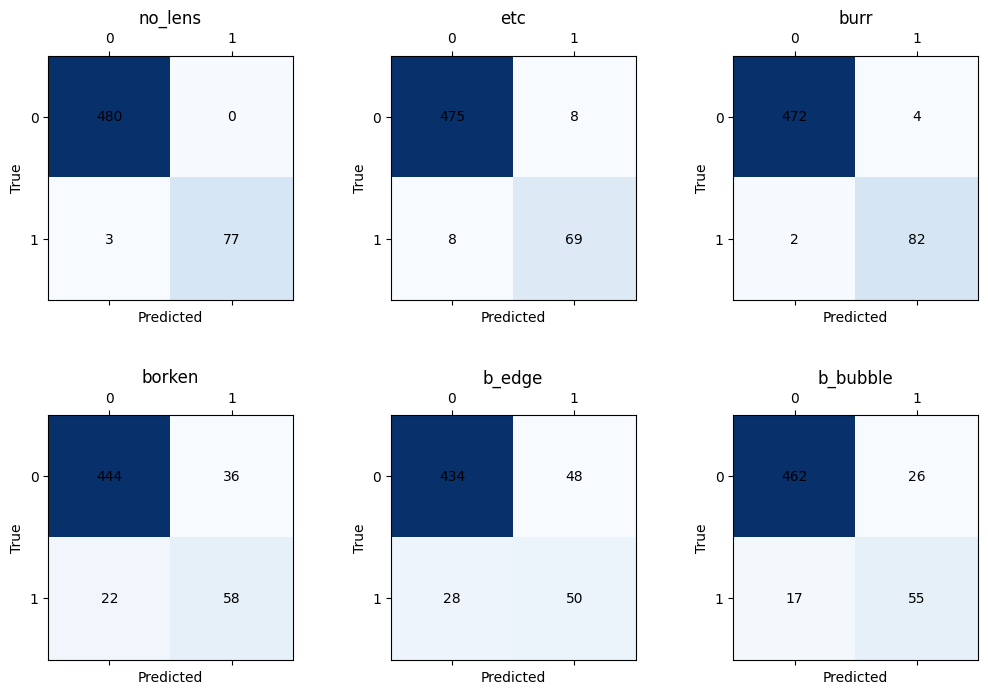

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
labels = ['no_lens', 'etc', 'burr', 'borken', 'b_edge', 'b_bubble']

# 멀티레이블 분류의 정밀도, 재현율, F1 점수 계산
precision = precision_score(actual, origin_result, average='micro')
recall = recall_score(actual, origin_result, average='micro')
f1 = f1_score(actual, origin_result, average='micro')
accuracy = accuracy_score(actual, origin_result)

print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1))
print('Accuracy: {:.5f}'.format(accuracy))

mcm = multilabel_confusion_matrix(actual, origin_result)
fig, ax = plt.subplots(2, 3, figsize=(12, 8))  # 2x3 그리드 생성
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # 서브플롯 간 간격 조정

# 각 레이블에 대한 confusion matrix 시각화
for i, (label_mcm) in enumerate(mcm):
    # 현재 서브플롯 선택
    row = i // 3
    col = i % 3
    cax = ax[row, col]

    # confusion matrix 표시
    cax.matshow(label_mcm, cmap='Blues')  # 색상 테마 선택

    # 축 레이블 설정
    cax.set_xlabel('Predicted')
    cax.set_ylabel('True')
    cax.set_title(labels[i])

    # 각 셀에 대한 값 표시
    for (x, y), value in np.ndenumerate(label_mcm):
        cax.text(x, y, f'{value}', va='center', ha='center')

# 그래프 표시
plt.show()

Precision: 0.83375
Recall: 0.64522
F1 Score: 0.72747
Accuracy: 0.61964


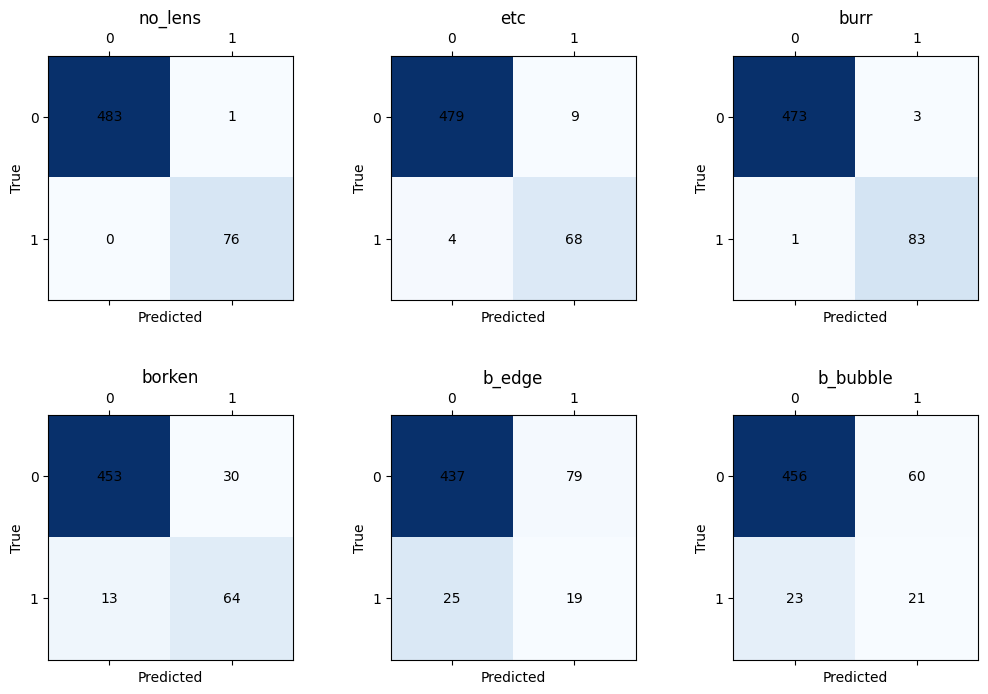

In [ ]:
# 멀티레이블 분류의 정밀도, 재현율, F1 점수 계산
precision = precision_score(actual, TH_result, average='micro')
recall = recall_score(actual, TH_result, average='micro')
f1 = f1_score(actual, TH_result, average='micro')
accuracy = accuracy_score(actual, TH_result)

print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1))
print('Accuracy: {:.5f}'.format(accuracy))

mcm = multilabel_confusion_matrix(actual, TH_result)
fig, ax = plt.subplots(2, 3, figsize=(12, 8))  # 2x3 그리드 생성
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # 서브플롯 간 간격 조정

# 각 레이블에 대한 confusion matrix 시각화
for i, (label_mcm) in enumerate(mcm):
    # 현재 서브플롯 선택
    row = i // 3
    col = i % 3
    cax = ax[row, col]

    # confusion matrix 표시
    cax.matshow(label_mcm, cmap='Blues')  # 색상 테마 선택

    # 축 레이블 설정
    cax.set_xlabel('Predicted')
    cax.set_ylabel('True')
    cax.set_title(labels[i])

    # 각 셀에 대한 값 표시
    for (x, y), value in np.ndenumerate(label_mcm):
        cax.text(x, y, f'{value}', va='center', ha='center')

# 그래프 표시
plt.show()